In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl"
STEPS_DIR = f"{BASE_DIR}/steps"
DATASETS_DIR = f"{BASE_DIR}/datasets"

In [3]:
EXP_VERSION = "rce-v0"

steps_fn = sorted(glob(STEPS_DIR + f"/{EXP_VERSION}*/*/*.pkl"))

In [4]:
fp = f"{DATASETS_DIR}/air.mon.ltm.1981-2010.nc"

if not os.path.exists(fp):
    print("Downloading NCEP air data ...")
    ncep_url = (
        "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/"
    )
    ncep_air = xr.open_dataset(
        ncep_url + "pressure/air.mon.1981-2010.ltm.nc#mode=bytes",
        use_cftime=True,
    )
    ncep_air.to_netcdf(fp)
else:
    print("Loading NCEP air data ...")
    ncep_air = xr.open_dataset(fp, use_cftime=True)

coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim="lat")
Tobs = (ncep_air.air * weight).mean(dim=("lat", "lon", "time"))

Loading NCEP air data ...


In [5]:
import pickle

with open(steps_fn[-1], "rb") as file:
    steps = pickle.load(file)

In [6]:
def get_T_diff(next_obs):
    Tprofile_climlab = xr.DataArray(
        next_obs.to("cpu")[0], coords={"level": Tobs.level.values[::-1]}
    )
    T_diff_climlab = Tobs.sel(level=[100, 200]) - Tprofile_climlab.sel(
        level=[100, 200]
    )
    T_diff_climlab = np.abs(T_diff_climlab)
    return T_diff_climlab

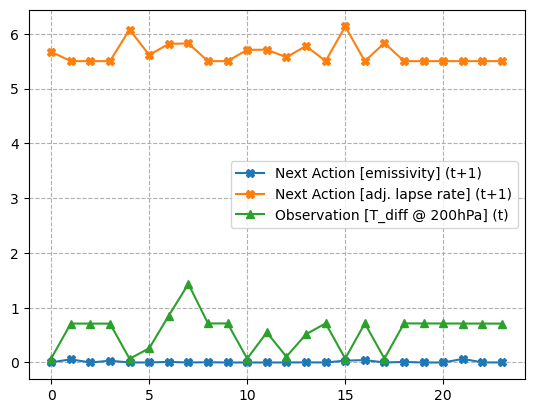

In [7]:
plt.plot(
    [x["actions"][0][0].item() for x in steps[-24:]],
    label="Next Action [emissivity] (t+1)",
    marker="X",
)
plt.plot(
    [x["actions"][0][1].item() for x in steps[-24:]],
    label="Next Action [adj. lapse rate] (t+1)",
    marker="X",
)
plt.plot(
    [get_T_diff(x["next_obs"])[1] for x in steps[-24:]],
    label="Observation [T_diff @ 200hPa] (t)",
    marker="^",
)
plt.grid(True, ls="--")
plt.legend()
plt.show()